In [1]:
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
import re
import numpy as np

In [2]:
seq_path = r"E:\Archive\PG_at_UCL\bioinfo\paralogs of PGH2.txt"
p_list = []
with open(seq_path, 'r') as f:
    contents = f.readlines()
    for content in contents:
        if re.match(r'\w', content):
            p_list.append(content)
print(len(p_list))

6


In [3]:
p_list

['MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTRTGFYGENCSTPEFLTRIKLFLKPTPNTVHYILTHFKGFWNVVNNIPFLRNAIMSYVLTSRSHLIDSPPTYNADYGYKSWEAFSNLSYYTRALPPVPDDCPTPLGVKGKKQLPDSNEIVEKLLLRRKFIPDPQGSNMMFAFFAQHFTHQFFKTDHKRGPAFTNGLGHGVDLNHIYGETLARQRKLRLFKDGKMKYQIIDGEMYPPTVKDTQAEMIYPPQVPEHLRFAVGQEVFGLVPGLMMYATIWLREHNRVCDVLKQEHPEWGDEQLFQTSRLILIGETIKIVIEDYVQHLSGYHFKLKFDPELLFNKQFQYQNRIAAEFNTLYHWHPLLPDTFQIHDQKYNYQQFIYNNSILLEHGITQFVESFTRQIAGRVAGGRNVPPAVQKVSQASIDQSRQMKYQSFNEYRKRFMLKPYESFEELTGEKEMSAELEALYGDIDAVELYPALLVEKPRPDAIFGETMVEVGAPFSLKGLMGNVICSPAYWKPSTFGGEVGFQIINTASIQSLICNNVKGCPFTSFSVPDPELIKTVTINASSSRSGLDDINPTVLLKERSTEL\n',
 'MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGICVRFGLDRYQCDCTRTGYSGPNCTIPGLWTWLRNSLRPSPSFTHFLLTHGRWFWEFVNATFIREMLMRLVLTVRSNLIPSPPTYNSAHDYISWESFSNVSYYTRILPSVPKDCPTPMGTKGKKQLPDAQLLARRFLLRRKFIPDPQGTNLMFAFFAQHFTHQFFKTSGKMGPGFTKALGHGVDLGHIYGDNLERQYQLRLFKDGKLKYQVLDGEMYPPSVEEAPVLMHYPRGIPPQSQMAVGQEVFGLLPGLMLYATLWLREHNRVCDLLKAEHPTWGDEQLFQTTRLILIGETIKIVIEEYVQQLSGYFLQLKFDPELLFGVQFQYRNRIAMEFNHLYHWH

In [4]:
class NW():
    def __init__(
            self, seqa:str, seqb:str, 
            match, mismatch, gap
    ):
        self.seqa = seqa
        self.seqb = seqb
        self.match_score = match
        self.mismatch_score = mismatch
        self.gap_score = gap
        self.matrix = np.zeros((len(seqa)+1, len(seqb)+1))
        self.matrix.fill(np.inf)
        self.matrix[:, 0] = [self.gap_score * i for i in range(self.matrix.shape[0])]
        self.matrix[0, :] = [self.gap_score * j for j in range(self.matrix.shape[1])]

                
    def _scoring(self):
        for row_idx, i in enumerate(self.matrix):
            for col_idx, j in enumerate(i):
                
                if j != np.inf:
                    pass
                else:
                    '''
                    lt: right top (diagonal)
                    lt_: rt + match or mismatch
                    rb: right bottom
                    lt: left top
                    '''
                    lt = self.matrix[row_idx-1, col_idx-1]
                    lt_ = lt + self.match_score if self.seqa[row_idx-1] == self.seqb[col_idx-1] else lt + self.mismatch_score
                    
                    lb = self.matrix[row_idx, col_idx-1]
                    rt = self.matrix[row_idx-1, col_idx]

                    score = np.max([lt_, lb+self.gap_score, rt+self.gap_score])

                    self.matrix[row_idx, col_idx] = score

        return self.matrix
    
    def _traceback(self,):
        seqa_output, seqb_output = [], []
        row = self.matrix.shape[0] - 1
        col = self.matrix.shape[1] - 1

        while row > 0 or col > 0:

            # How N&W gets rid of local optimum

            #print(f'row: {row}, col: {col}')
            current_score = self.matrix[row, col]

            if row > 0 and col >0:
                #match_val = self.match_score if self.seqa[row-1] == self.seqb[col-1] else self.mismatch_score
                match_val = self.match_score if self.seqa[row-1] == self.seqb[col-1] else self.mismatch_score
                #print(match_val)
                if current_score == self.matrix[row-1, col - 1] + match_val:
                    seqa_output.append(self.seqa[row-1])
                    seqb_output.append(self.seqb[col-1])
                    
                    row -= 1
                    col -= 1
                    continue
                
            if col>0 and current_score == self.matrix[row, col - 1] + self.gap_score:
                seqa_output.append('-')
                seqb_output.append(self.seqb[col-1])
                col -= 1
                continue

            if row > 0 and current_score == self.matrix[row - 1, col] + self.gap_score:
                
                seqa_output.append(self.seqa[row-1])
                seqb_output.append('-')
                row -= 1
                
                continue

                
        seqa_output.reverse(), seqb_output.reverse()
        return seqa_output, seqb_output
    
    def align(self):
        score_matrix = self._scoring()
        #print(score_matrix)
        seqa_output, seqb_output = self._traceback()
        return seqa_output, seqb_output

In [ ]:
def msa_matrix(
        p_list:list, 
        match_score:int|float, mismatch_score:int|float, gap_score:int|float
):
    matrix = np.zeros((len(p_list), len(p_list)))
    for i, seqa, in enumerate(p_list[:-1]):
        for j, seqb in enumerate(p_list[i+1:]):
            score = 0
            nw = NW(seqa, seqb, match=match_score, mismatch=mismatch_score, gap=gap_score)
            seqa_, seqb_ = nw.align()

            for k in range(len(seqa_)):
                if seqa_[k] == seqb_[k]:
                    score += nw.match_score
                elif seqa_[k] != seqb_[k] and seqa_[k] != '-' and seqb_[k] != '-':
                    score += nw.mismatch_score
                else:
                    score =+ nw.gap_score

            #print({f'i:{i}, j:{i+j+1}'})
            print(score)
            matrix[i][i+j+1] = score
    return matrix + matrix.T
m = msa_matrix(p_list, match_score=1, mismatch_score=-1, gap_score=-2)

3
-10
-2
-1
-22
-11
-2
-9
-6
-5
-2
-6
-1
-4
-2


In [10]:
def identity_matrix(
        p_list:list, 
        match_score:int|float, mismatch_score:int|float, gap_score:int|float
):
    matrix = np.zeros((len(p_list), len(p_list)))
    for i, seqa, in enumerate(p_list[:-1]):
        for j, seqb in enumerate(p_list[i+1:]):
            score = 0
            nw = NW(seqa, seqb, match=match_score, mismatch=mismatch_score, gap=gap_score)
            seqa_, seqb_ = nw.align()

            for k in range(len(seqa_)):
                if seqa_[k] == seqb_[k]:
                    score += 1
                else:
                    score += 0
            print(f'score: {score}; length: {min(len(seqa), len(seqb))}')
            matrix[i][i+j+1] = score/min(len(seqa), len(seqb))

    matrix_ = matrix + matrix.T
    np.fill_diagonal(matrix_, 1)
    return matrix_

im = identity_matrix(p_list, match_score=1, mismatch_score=-1, gap_score=-2)
print(im)

score: 379; length: 600
score: 174; length: 605
score: 177; length: 605
score: 224; length: 605
score: 157; length: 605
score: 174; length: 600
score: 181; length: 600
score: 217; length: 600
score: 162; length: 600
score: 387; length: 713
score: 334; length: 713
score: 372; length: 713
score: 348; length: 746
score: 505; length: 715
score: 339; length: 715
[[1.         0.63166667 0.28760331 0.29256198 0.37024793 0.25950413]
 [0.63166667 1.         0.29       0.30166667 0.36166667 0.27      ]
 [0.28760331 0.29       1.         0.542777   0.4684432  0.52173913]
 [0.29256198 0.30166667 0.542777   1.         0.46648794 0.70629371]
 [0.37024793 0.36166667 0.4684432  0.46648794 1.         0.47412587]
 [0.25950413 0.27       0.52173913 0.70629371 0.47412587 1.        ]]


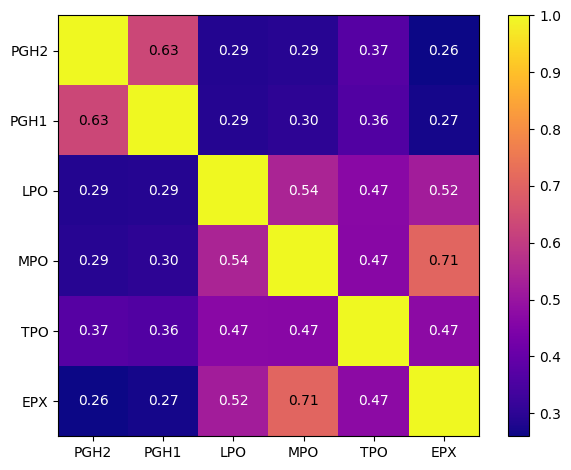

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
image = ax.imshow(im, cmap='plasma')

labels=['PGH2', 'PGH1', 'LPO', 'MPO', 'TPO', 'EPX']

for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if im[i,j]==1:
            continue
        if im[i,j] > 0.6:
            text = ax.text(
                j, i, f'{im[i,j]:.2f}', 
                ha = 'center', va = 'center', color = 'black'
            )

        else:
            text = ax.text(
                j, i, f'{im[i,j]:.2f}', 
                ha = 'center', va = 'center', color = 'white'
            )            

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.colorbar(image)
plt.tight_layout()
plt.savefig('identity_score_matrix.png', dpi = 600)

In [17]:
m

array([[  0.,   3., -10.,  -2.,  -1., -22.],
       [  3.,   0., -11.,  -2.,  -9.,  -6.],
       [-10., -11.,   0.,  -5.,  -2.,  -6.],
       [ -2.,  -2.,  -5.,   0.,  -1.,  -4.],
       [ -1.,  -9.,  -2.,  -1.,   0.,  -2.],
       [-22.,  -6.,  -6.,  -4.,  -2.,   0.]])

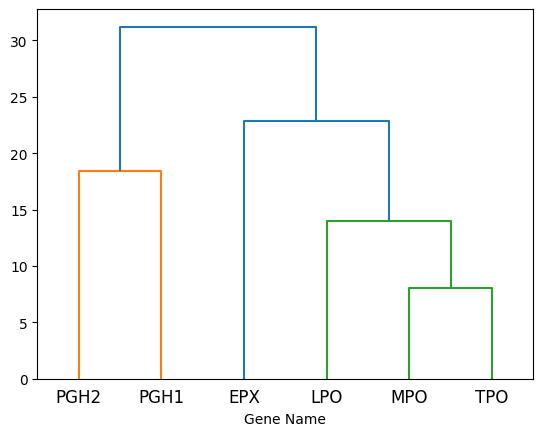

In [ ]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
z = linkage(m, 'ward')
f = fcluster(z,2,'distance')
ax, fig = plt.subplots()

fig = dendrogram(z, labels=['PGH2', 'PGH1', 'LPO', 'MPO', 'TPO', 'EPX'])
plt.xlabel('Gene Name')
plt.savefig('nw_for_msa.png', dpi = 600)